# Example of Graph Neural Network

In [1]:
%load_ext autoreload
%autoreload 2

# System imports
import os
import sys
import yaml

# External imports
import matplotlib.pyplot as plt
import scipy as sp
from sklearn.decomposition import PCA
from sklearn.metrics import auc
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

# import seaborn as sns
import torch
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger, WandbLogger
import wandb

import warnings

warnings.filterwarnings("ignore")
sys.path.append("../../..")
device = "cuda" if torch.cuda.is_available() else "cpu"

## Setup

In [2]:
from LightningModules.GNN.Models.interaction_gnn import InteractionGNN
from LightningModules.GNN.Models.hetero_gnn import HeteroGNN

In [12]:
with open("example_gnn.yaml") as f:
    hparams = yaml.load(f, Loader=yaml.FullLoader)

In [13]:
model = InteractionGNN(hparams)

## Train GNN

In [5]:
logger = WandbLogger(
    project=hparams["project"], group="InitialTest", save_dir=hparams["artifacts"]
)
trainer = Trainer(
    gpus=1, max_epochs=hparams["max_epochs"], logger=logger
)  # , precision=16)
trainer.fit(model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Setting up dataset
Loading events from /global/cfs/cdirs/m3443/data/ITk-upgrade/processed/filter_processed/0GeV_barrel_v3/train


100%|██████████| 40/40 [00:02<00:00, 13.67it/s]


Events loaded!


40it [00:01, 20.37it/s]


Events processed!
Loading events from /global/cfs/cdirs/m3443/data/ITk-upgrade/processed/filter_processed/0GeV_barrel_v3/val


100%|██████████| 20/20 [00:01<00:00, 16.30it/s]


Events loaded!


20it [00:00, 20.25it/s]


Events processed!
Loading events from /global/cfs/cdirs/m3443/data/ITk-upgrade/processed/filter_processed/0GeV_barrel_v3/test


100%|██████████| 10/10 [00:00<00:00, 13.57it/s]


Events loaded!


10it [00:00, 20.23it/s]
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Events processed!


wandb: Currently logged in as: murnanedaniel (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                   | Type       | Params
------------------------------------------------------
0 | node_encoder           | Sequential | 34.6 K
1 | edge_encoder           | Sequential | 66.9 K
2 | edge_network           | Sequential | 83.3 K
3 | node_network           | Sequential | 83.3 K
4 | output_edge_classifier | Sequential | 84.0 K
------------------------------------------------------
352 K     Trainable params
0         Non-trainable params
352 K     Total params
1.409     Total estimated model params size (MB)


Epoch 0:  67%|██████▋   | 40/60 [01:10<00:35,  1.77s/it, loss=0.478, v_num=4hnm]
Validating: 0it [00:00, ?it/s]
Epoch 1:  67%|██████▋   | 40/60 [01:11<00:35,  1.78s/it, loss=0.329, v_num=4hnm]
Validating: 0it [00:00, ?it/s]
Epoch 2:  67%|██████▋   | 40/60 [01:11<00:35,  1.78s/it, loss=0.299, v_num=4hnm]
Validating: 0it [00:00, ?it/s]
Epoch 3:  67%|██████▋   | 40/60 [01:11<00:35,  1.78s/it, loss=0.276, v_num=4hnm]
Validating: 0it [00:00, ?it/s]
Epoch 4:  67%|██████▋   | 40/60 [01:11<00:35,  1.78s/it, loss=0.264, v_num=4hnm]
Validating: 0it [00:00, ?it/s]
Epoch 5:  67%|██████▋   | 40/60 [01:11<00:35,  1.78s/it, loss=0.254, v_num=4hnm]
Validating: 0it [00:00, ?it/s]
Epoch 6:  67%|██████▋   | 40/60 [01:11<00:35,  1.78s/it, loss=0.247, v_num=4hnm]
Validating: 0it [00:00, ?it/s]
Epoch 7:  67%|██████▋   | 40/60 [01:11<00:35,  1.78s/it, loss=0.241, v_num=4hnm]
Validating: 0it [00:00, ?it/s]
Epoch 8:  67%|██████▋   | 40/60 [01:11<00:35,  1.78s/it, loss=0.238, v_num=4hnm]
Validating: 0it [00:00,

## Build Classified Files

In [4]:
from notebooks.ITk.utils import GNNInferenceCallback

In [5]:
# checkpoint_path = "/global/cfs/cdirs/m3443/data/lightning_models/lightning_checkpoints/ITk_1GeVSignal_GNN/1j1uwy9r/checkpoints/epoch=76-step=38499.ckpt"
checkpoint_path = "/global/cfs/cdirs/m3443/data/lightning_models/lightning_checkpoints/ITk_1GeVSignal_HeteroGNN/z8txsx3g/checkpoints/epoch=84-step=19786.ckpt"
checkpoint = torch.load(checkpoint_path)
model = HeteroGNN.load_from_checkpoint(checkpoint_path).to(device)
model.eval();

In [9]:
model.hparams["datatype_split"] = [100, 10, 10]
model.setup(stage="fit")

In [10]:
model = model.to(device)

In [11]:
builder = GNNInferenceCallback(model, overwrite=False)

In [12]:
builder.infer()

Training finished, running inference to filter graphs...
Building train


100%|██████████| 100/100 [03:39<00:00,  2.19s/it]


Building val


100%|██████████| 10/10 [00:21<00:00,  2.17s/it]


Building test


100%|██████████| 10/10 [00:24<00:00,  2.40s/it]


In [ ]:
os.makedirs(output_dir, exist_ok=True)

with torch.no_grad():
    for batch in model.train_dataloader():

        print(batch)

        output = model.shared_evaluation(batch.to(device), 0, log=False)

        print(output)
        print(os.path.split(batch.event_file[0])[-1])

        gnn_results = np.vstack(
            [
                batch.edge_index.cpu().numpy(),
                output["score"][: int(len(output["score"]) / 2)].cpu().numpy(),
                output["truth"].cpu().numpy(),
            ]
        )

        gnn_recarray = np.rec.fromarrays(
            gnn_results, names=["senders", "receivers", "score", "truth"]
        )

        with open(
            os.path.join(
                output_dir, os.path.split(batch.event_file[0])[-1][-4:] + ".npz"
            ),
            "wb",
        ) as f:
            np.save(f, gnn_recarray)

# Performance

## Edgewise Performance

In [14]:
checkpoint_path = "/global/cfs/cdirs/m3443/data/lightning_models/lightning_checkpoints/ITk_1GeVSignal_GNN/1j1uwy9r/checkpoints/epoch=76-step=38499.ckpt"
checkpoint = torch.load(checkpoint_path)
model = InteractionGNN.load_from_checkpoint(checkpoint_path).to(device)
model.eval();

In [7]:
barrel_checkpoint_path = "/global/cfs/cdirs/m3443/data/lightning_models/lightning_checkpoints/ITk_1GeVSignal_Barrel_GNN/i7mwr3nr/checkpoints/epoch=74-step=29999.ckpt"
barrel_checkpoint = torch.load(barrel_checkpoint_path)
barrel_model = InteractionGNN.load_from_checkpoint(barrel_checkpoint_path).to(device)
barrel_model.eval();

In [15]:
model.hparams["datatype_split"] = [200, 100, 50]
model.setup(stage="fit")

In [70]:
barrel_model.hparams["datatype_split"] = [100, 100, 50]
barrel_model.setup(stage="fit")

In [5]:
def calc_eta(r, z):
    theta = np.arctan2(r, z)
    return -1.0 * np.log(np.tan(theta / 2.0))

In [6]:
def get_performance(model, batch, edge_cut):
    with torch.no_grad():
        results = model.shared_evaluation(batch, 0, log=False)
        scores = results["score"][: int(len(results["score"]) / 2)]

    return scores > edge_cut, scores, batch.pid_signal, batch.y_pid

In [7]:
edge_cut = 0.3
eta_width = 0.5
eta_cuts = np.arange(-4, 4.5, eta_width)
batch_range = np.arange(0, 50)

eta_eff_list = []
eta_signal_pur_list = []
eta_total_pur_list = []

for batch_idx in tqdm(batch_range):

    batch = model.testset[batch_idx].to(device)

    preds, scores, signal_truth, all_truth = get_performance(
        model, batch, edge_cut
    )
    
    edge_preds = batch.edge_index[:, preds]
    edge_signal_truth = batch.edge_index[:, signal_truth]
    edge_all_truth = batch.edge_index[:, all_truth]
    signal_true_positives = signal_truth[preds]
    all_true_positives = all_truth[preds]
   
    eta_hits = calc_eta(batch.x[:, 0].cpu(), batch.x[:, 2].cpu())
    av_eta_preds = (eta_hits[edge_preds[0]] + eta_hits[edge_preds[1]]) / 2
    av_eta_signal_true = (eta_hits[edge_signal_truth[0]] + eta_hits[edge_signal_truth[1]]) / 2
    av_eta_total_true = (eta_hits[edge_all_truth[0]] + eta_hits[edge_all_truth[1]]) / 2

    for eta1, eta2 in zip(eta_cuts[:-1], eta_cuts[1:]):
        edge_eta_pred = (av_eta_preds >= eta1) & (av_eta_preds <= eta2)
        edge_eta_signal_true = (av_eta_signal_true >= eta1) & (av_eta_signal_true <= eta2)
        edge_eta_total_true = (av_eta_total_true >= eta1) & (av_eta_total_true <= eta2)
        eta_signal_true_positives = signal_true_positives[edge_eta_pred]
        eta_total_true_positives = all_true_positives[edge_eta_pred]
        
        eff = eta_signal_true_positives.sum().item() / max(1, edge_eta_signal_true.sum().item())
        signal_pur = eta_signal_true_positives.sum().item() / max(1, eta_signal_true_positives.shape[0])
        total_pur = eta_total_true_positives.sum().item() / max(1, eta_total_true_positives.shape[0])

        eta_eff_list.append(eff)
        eta_signal_pur_list.append(signal_pur)
        eta_total_pur_list.append(total_pur)

100%|██████████| 50/50 [01:03<00:00,  1.27s/it]


In [8]:
eta_eff_reshape = np.array(eta_eff_list).reshape(
     len(batch_range), eta_cuts.shape[0] - 1
)
eta_signal_pur_reshape = np.array(eta_signal_pur_list).reshape(
    len(batch_range), eta_cuts.shape[0] - 1
)
eta_total_pur_reshape = np.array(eta_total_pur_list).reshape(
    len(batch_range), eta_cuts.shape[0] - 1
)

<ErrorbarContainer object of 3 artists>

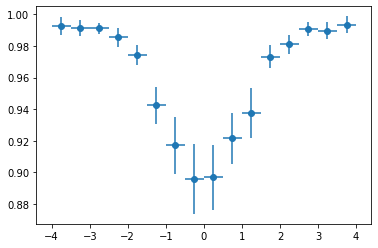

In [9]:
eta_center = (eta_cuts[:-1] + eta_cuts[1:]) / 2
plt.errorbar(eta_center, eta_eff_reshape.mean(0), eta_eff_reshape.std(0), eta_width/2, fmt="o")
# plt.ylim(0.96, 1.005)

(0.7, 1.005)

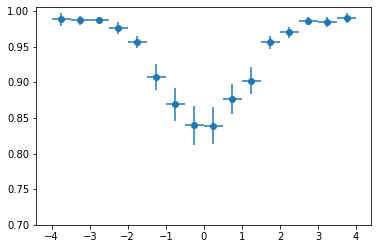

In [31]:
eta_center = (eta_cuts[:-1] + eta_cuts[1:]) / 2
plt.errorbar(eta_center, eta_eff_reshape.mean(0), eta_eff_reshape.std(0), eta_width/2, fmt="o")
plt.ylim(0.7, 1.005)

True positives of signal matching PIDs

<ErrorbarContainer object of 3 artists>

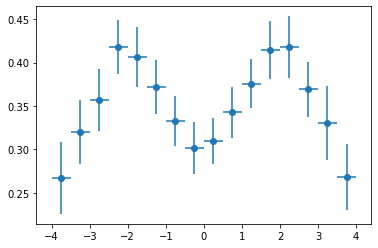

In [10]:
eta_center = (eta_cuts[:-1] + eta_cuts[1:]) / 2
plt.errorbar(eta_center, eta_signal_pur_reshape.mean(0), eta_signal_pur_reshape.std(0), eta_width/2, fmt="o")
# plt.ylim(0., 0.007)

True positives of all matching PIDs

<ErrorbarContainer object of 3 artists>

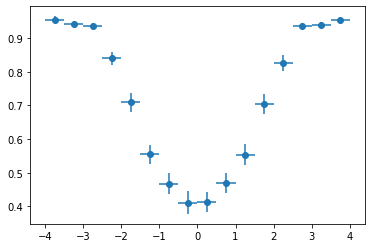

In [11]:
eta_center = (eta_cuts[:-1] + eta_cuts[1:]) / 2
plt.errorbar(eta_center, eta_total_pur_reshape.mean(0), eta_total_pur_reshape.std(0), eta_width/2, fmt="o")
# plt.ylim(0., 0.007)

In [58]:
edge_cut = 0.5
pt_min, pt_max = 1000, 10000
pt_cuts = np.logspace(np.log10(pt_min), np.log10(pt_max), 20)
batch_range = np.arange(0, 50)

pt_eff_list = []
pt_pur_list = []

for batch_idx in tqdm(batch_range):

    batch = model.testset[batch_idx].to(device)

    
    preds, scores, truth, _ = get_performance(
        model, batch, edge_cut
    )
    
    edge_preds = batch.edge_index[:, preds]
    edge_truth = batch.edge_index[:, truth]
    true_positives = truth[preds]
    
    av_pt_preds = (batch.pt[edge_preds[0]] + batch.pt[edge_preds[1]]) / 2
    av_pt_true = (batch.pt[edge_truth[0]] + batch.pt[edge_truth[1]]) / 2

    for pt1, pt2 in zip(pt_cuts[:-1], pt_cuts[1:]):
        edge_pt_pred = (av_pt_preds >= pt1) & (av_pt_preds <= pt2)
        edge_pt_true = (av_pt_true >= pt1) & (av_pt_true <= pt2)
        pt_true_positives = true_positives[edge_pt_pred]

        pt_eff_list.append(
            pt_true_positives.sum().item() / max(1, edge_pt_true.sum().item())
        )
        pt_pur_list.append(
            pt_true_positives.sum().item() / max(1, pt_true_positives.shape[0])
        )

100%|██████████| 50/50 [00:57<00:00,  1.16s/it]


In [59]:
pt_eff_reshape = np.array(pt_eff_list).reshape(len(batch_range), pt_cuts.shape[0] - 1)
pt_pur_reshape = np.array(pt_pur_list).reshape(len(batch_range), pt_cuts.shape[0] - 1)

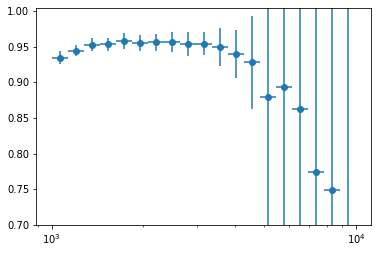

In [60]:
pt_center = (pt_cuts[:-1] + pt_cuts[1:]) / 2
pt_widths = (pt_cuts[1:] - pt_cuts[:-1]) /2
plt.errorbar(pt_center, pt_eff_reshape.mean(0), pt_eff_reshape.std(0), pt_widths, fmt="o")
plt.ylim(0.7, 1.005)
plt.xscale("log")

True positives of signal matching PIDs

(0.7, 1.005)

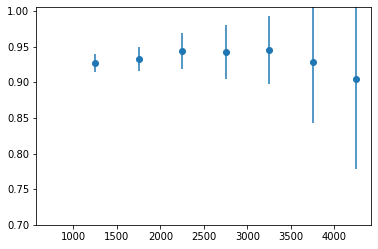

In [34]:
pt_center = (pt_cuts[:-1] + pt_cuts[1:]) / 2
plt.errorbar(pt_center, pt_pur_reshape.mean(0), pt_pur_reshape.std(0), fmt="o")
plt.ylim(0.7, 1.005)

True positives of all matching PIDs

(0.75, 1.005)

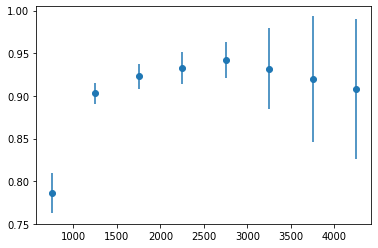

In [96]:
pt_center = (pt_cuts[:-1] + pt_cuts[1:]) / 2
plt.errorbar(pt_center, pt_pur_reshape.mean(0), pt_pur_reshape.std(0), fmt="o")
plt.ylim(0.75, 1.005)

## Predict Tracks

In [9]:
model = model.to(device)
barrel_model = barrel_model.to(device)

In [2]:
from sklearn.cluster import DBSCAN


def tracks_from_gnn(
    hit_id,
    score,
    senders,
    receivers,
    edge_score_cut=0.0,
    epsilon=0.25,
    min_samples=2,
    **kwargs
):

    n_nodes = hit_id.shape[0]
    if edge_score_cut > 0:
        cuts = score > edge_score_cut
        score, senders, receivers = score[cuts], senders[cuts], receivers[cuts]

    # prepare the DBSCAN input, which the adjancy matrix with its value being the edge socre.
    e_csr = sp.sparse.csr_matrix(
        (score, (senders, receivers)), shape=(n_nodes, n_nodes), dtype=np.float32
    )
    # rescale the duplicated edges
    e_csr.data[e_csr.data > 1] = e_csr.data[e_csr.data > 1] / 2.0
    # invert to treat score as an inverse distance
    e_csr.data = 1 - e_csr.data
    # make it symmetric
    e_csr_bi = sp.sparse.coo_matrix(
        (
            np.hstack([e_csr.tocoo().data, e_csr.tocoo().data]),
            np.hstack(
                [
                    np.vstack([e_csr.tocoo().row, e_csr.tocoo().col]),
                    np.vstack([e_csr.tocoo().col, e_csr.tocoo().row]),
                ]
            ),
        )
    )

    # DBSCAN get track candidates
    clustering = DBSCAN(
        eps=epsilon, metric="precomputed", min_samples=min_samples
    ).fit_predict(e_csr_bi)
    track_labels = np.vstack(
        [np.unique(e_csr_bi.tocoo().row), clustering[np.unique(e_csr_bi.tocoo().row)]]
    )
    track_labels = pd.DataFrame(track_labels.T)
    track_labels.columns = ["hit_id", "track_id"]
    new_hit_id = np.apply_along_axis(lambda x: hit_id[x], 0, track_labels.hit_id.values)
    tracks = pd.DataFrame.from_dict(
        {"hit_id": new_hit_id, "track_id": track_labels.track_id}
    )
    return tracks

In [63]:
sample = model.valset[0]

In [64]:
with torch.no_grad():
    results = model.shared_evaluation(sample.to(device), 0, log=False)

In [65]:
sample = sample.cpu()

In [66]:
preds = results["score"][: int(len(results["score"]) / 2)]

In [82]:
reconstructed = tracks_from_gnn(
    sample.hid,
    preds.cpu().numpy(),
    sample.edge_index[0],
    sample.edge_index[1],
    epsilon=0.1,
)

## Debug!

In [27]:
sample.event_file

'/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/full_events_v4/event000010596'

In [22]:
from notebooks.ITk.utils import *
# Read yaml config 
with open("tracking_config.yaml", "r") as f:
    config = yaml.safe_load(f)

# Load in files
files = list_files(os.path.join(config["graph_input_dir"], "train"))[:10]

sample = torch.load(files[0], map_location="cpu")

In [8]:
sample.edge_index.shape

torch.Size([2, 535183])

In [23]:
reconstructed = tracks_from_gnn(
    sample.hid,
    sample.y.float().cpu(),
    sample.edge_index[0],
    sample.edge_index[1],
    epsilon=0.1,
)

In [12]:
reconstructed = tracks_from_gnn(
    sample.hid,
    sample.scores.float().cpu(),
    sample.edge_index[0],
    sample.edge_index[1],
    epsilon=0.1,
)

In [29]:
preds = results["score"][: int(len(results["score"]) / 2)]

In [6]:
len(reconstructed.track_id.unique())

14485

In [49]:
particles

,particle_id,subevent,barcode,px,py,pz,pt,eta,vx,vy,vz,radius,status,charge,pdgId,pass,vProdNIn,vProdNOut,vProdStatus,vProdBarcode
0,5,0,5,-58039.0000,19474.5000,19474.5000,61.219100,-0.700640,-0.001258,0.004029,-8.84568,0.004221,22,0.666667,6,NO,2,3,0,-3
1,6,0,6,-67456.8000,-132594.0000,-132594.0000,148.766000,-0.340530,-0.001258,0.004029,-8.84568,0.004221,22,-0.666667,-6,NO,2,3,0,-3
2,7,0,7,125496.0000,113119.0000,113119.0000,168.953000,-3.185210,-0.001258,0.004029,-8.84568,0.004221,23,1.000000,21,NO,2,3,0,-3
3,10,0,10,-90454.3000,29370.4000,29370.4000,95.103100,-0.579145,-0.001258,0.004029,-8.84568,0.004221,44,0.666667,6,NO,1,1,0,-6
4,11,0,11,-111485.0000,-119152.0000,-119152.0000,163.176000,-0.326275,-0.001258,0.004029,-8.84568,0.004221,44,-0.666667,-6,NO,1,1,0,-7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99112,68400200072,6840,200072,170.7470,423.3610,423.3610,0.456496,0.312605,-23.469200,-3.507630,1879.09000,23.729900,1,1.000000,1000010020,NO,1,4,1121,-200071
99113,68400200073,6840,200073,-132.6190,-382.7040,-382.7040,0.405031,0.969193,-23.469200,-3.507630,1879.09000,23.729900,1,1.000000,1000010020,NO,1,4,1121,-200071
99114,68400200074,6840,200074,48.6365,298.2550,298.2550,0.302195,0.503916,-23.469200,-3.507630,1879.09000,23.729900,1,-1.000000,-211,NO,1,4,1121,-200071
99115,68401000099,6840,1000099,423.0480,198.5240,198.5240,0.467313,3.331250,19.114700,125.710000,1726.44000,127.155000,1,-1.000000,-211,NO,1,2,1111,-200065


In [38]:
truth

,hit_id,x,y,z,cluster_index_1,cluster_index_2,particle_id,hardware,cluster_x_1,cluster_y_1,...,phi_angle_1,norm_x,norm_y,norm_z_1,cluster_x_2,cluster_y_2,cluster_z_2,eta_angle_2,phi_angle_2,norm_z_2
0,0,-45.0903,-15.9913,-263.00,0,-1,66810001575,PIXEL,-45.0903,-15.9913,...,1.249050,0.0,0.0,-1.0,-1.000,-1.000,-1.00,-1.000000,-1.000000,-1.0
1,1,-37.7384,-18.1501,-263.00,1,-1,1220,PIXEL,-37.7384,-18.1501,...,0.982794,0.0,0.0,-1.0,-1.000,-1.000,-1.00,-1.000000,-1.000000,-1.0
2,2,-36.6423,-10.1972,-263.00,2,-1,68210001436,PIXEL,-36.6423,-10.1972,...,0.982794,0.0,0.0,-1.0,-1.000,-1.000,-1.00,-1.000000,-1.000000,-1.0
3,3,-45.6745,-23.1734,-263.00,3,-1,0,PIXEL,-45.6745,-23.1734,...,0.982794,0.0,0.0,-1.0,-1.000,-1.000,-1.00,-1.000000,-1.000000,-1.0
4,4,-39.3053,-19.3953,-263.00,4,-1,66810001946,PIXEL,-39.3053,-19.3953,...,1.249050,0.0,0.0,-1.0,-1.000,-1.000,-1.00,-1.000000,-1.000000,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355217,353712,919.5980,-114.1280,2854.25,489874,489885,0,STRIP,930.5390,-115.6970,...,0.006379,0.0,0.0,1.0,930.588,-115.304,2860.75,1.324640,0.006379,-1.0
355218,353713,923.4590,-115.9750,2854.25,489875,489884,0,STRIP,930.3800,-116.9730,...,0.006379,0.0,0.0,1.0,930.409,-116.741,2860.75,1.324640,0.006379,-1.0
355219,353714,900.6060,-112.6450,2854.25,489875,489885,0,STRIP,930.3800,-116.9730,...,0.006379,0.0,0.0,1.0,930.588,-115.304,2860.75,1.324640,0.006379,-1.0
355220,353715,901.9260,-128.9420,2854.25,489876,489883,66900000128,STRIP,928.1910,-133.2290,...,0.006379,0.0,0.0,1.0,928.337,-132.209,2860.75,1.324640,0.006379,-1.0


In [50]:
(~particles.particle_id.isin(sample.pid.numpy())).sum()

89909

In [51]:
np.isin(np.unique(sample.pid.numpy()), particles.particle_id).sum()

9208

In [52]:
particles[particles.particle_id.isin(sample.pid.numpy())]

,particle_id,subevent,barcode,px,py,pz,pt,eta,vx,vy,vz,radius,status,charge,pdgId,pass,vProdNIn,vProdNOut,vProdStatus,vProdBarcode
449,661,0,661,11158.800,16261.300,16261.300,19.721700,-1.276430,-0.001258,0.004029,-8.84568,0.004221,1,1.0,-13,YES,1,2,0,-505
452,668,0,668,-1156.050,-532.229,-532.229,1.272680,0.214885,-0.001258,0.004029,-8.84568,0.004221,1,-1.0,11,YES,1,2,0,-509
477,700,0,700,298.064,377.502,377.502,0.480988,-2.407250,-0.001258,0.004029,-8.84568,0.004221,1,-1.0,-321,NO,3,5,0,-540
484,711,0,711,304.109,-409.381,-409.381,0.509975,-0.406456,-0.001258,0.004029,-8.84568,0.004221,1,-1.0,-211,NO,3,5,0,-544
485,712,0,712,-527.574,-876.848,-876.848,1.023330,-1.157520,-0.001258,0.004029,-8.84568,0.004221,1,1.0,211,YES,3,5,0,-544
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99090,68400200011,6840,200011,261.702,-379.634,-379.634,0.461096,1.440590,20.549400,-36.314400,101.88900,41.725400,1,1.0,211,NO,1,1,1201,-200039
99097,68400200038,6840,200038,-296.832,136.722,136.722,0.326806,0.198320,77.435400,247.393000,535.77100,259.228000,1,1.0,2212,NO,1,7,1121,-200054
99098,68400200040,6840,200040,256.991,499.641,499.641,0.561859,0.334338,77.435400,247.393000,535.77100,259.228000,1,1.0,2212,NO,1,7,1121,-200054
99099,68400200041,6840,200041,-320.753,-358.248,-358.248,0.480858,0.737052,77.435400,247.393000,535.77100,259.228000,1,1.0,2212,NO,1,7,1121,-200054


In [17]:
sample.y.sum() / sample.signal_true_edges.shape[1]

tensor(0.9738)

In [16]:
sample

Data(x=[116663, 3], cell_data=[116663, 11], pid=[116663], event_file='/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/full_events_v4/event000010596', hid=[116663], pt=[116663], primary=[116663], nhits=[116663], modulewise_true_edges=[2, 45817], signal_true_edges=[2, 6840], edge_index=[2, 582011], y=[582011], pedigree=[1], y_pid=[582011], pid_signal=[582011])

## Evaluate Tracks

In [9]:
def get_truth(evtid, raw_csv_path):
    """Return dataframes of true tracks and particles from CSV files."""

    file_prefix = os.path.join(raw_csv_path, "event00001{:04}".format(evtid))

    truth_fname = file_prefix + "-truth.csv"
    particle_fname = file_prefix + "-particles.csv"

    truth = pd.read_csv(truth_fname)
    # <TODO: why are there duplicated hit-id?, >
    truth.drop_duplicates(subset=["hit_id"], inplace=True)

    particles = pd.read_csv(particle_fname)
    particles["pt"] = particles.pt / 1000.0  # to be GeV

    return truth, particles

In [10]:
def evaluate_reco_tracks(
    truth: pd.DataFrame,
    reconstructed: pd.DataFrame,
    particles: pd.DataFrame,
    min_hits_truth=9,
    min_hits_reco=5,
    min_pt=1.0,
    max_pt=np.inf,
    max_eta=2.0,
    frac_reco_matched=0.5,
    frac_truth_matched=0.5,
    **kwargs
):
    """Return


    Args:
        truth: a dataframe with columns of ['hit_id', 'particle_id']
        reconstructed: a dataframe with columns of ['hit_id', 'track_id']
        particles: a dataframe with columns of
            ['particle_id', 'pt', 'eta', 'radius', 'vz'].
            where radius = sqrt(vx**2 + vy**2) and
            ['vx', 'vy', 'vz'] are the production vertex of the particle
        min_hits_truth: minimum number of hits for truth tracks
        min_hits_reco:  minimum number of hits for reconstructed tracks

    Returns:
        A tuple of (
            n_true_tracks: int, number of true tracks
            n_reco_tracks: int, number of reconstructed tracks
            n_matched_reco_tracks: int, number of reconstructed tracks
                matched to true tracks
            matched_pids: np.narray, a list of particle IDs matched
                by reconstructed tracks
        )
    """
    particles = particles[(particles.pt > min_pt) & (particles.eta.abs() < max_eta)]
    
    # just in case particle_id == 0 included in truth.
    if "particle_id" in truth.columns:
        truth = truth[truth.particle_id > 0]

    # get number of spacepoints in each reconstructed tracks
    n_reco_hits = (
        reconstructed.track_id.value_counts(sort=False)
        .reset_index()
        .rename(columns={"index": "track_id", "track_id": "n_reco_hits"})
    )

    # only tracks with a minimum number of spacepoints are considered
    n_reco_hits = n_reco_hits[n_reco_hits.n_reco_hits >= min_hits_reco]
    
    reconstructed = reconstructed[
        reconstructed.track_id.isin(n_reco_hits.track_id.values)
    ]

    # get number of spacepoints in each particle
    hits = truth.merge(particles, on="particle_id", how="left")
    n_true_hits = (
        hits.particle_id.value_counts(sort=False)
        .reset_index()
        .rename(columns={"index": "particle_id", "particle_id": "n_true_hits"})
    )
    

    # only particles leaves at least min_hits_truth spacepoints
    # and with pT >= min_pt are considered.
    particles = particles.merge(n_true_hits, on=["particle_id"], how="left")

    is_trackable = particles.n_true_hits >= min_hits_truth

    # event has 3 columnes [track_id, particle_id, hit_id]
    event = pd.merge(reconstructed, truth, on=["hit_id"], how="left")

    # n_common_hits and n_shared should be exactly the same
    # for a specific track id and particle id

    # Each track_id will be assigned to multiple particles.
    # To determine which particle the track candidate is matched to,
    # we use the particle id that yields a maximum value of n_common_hits / n_reco_hits,
    # which means the majority of the spacepoints associated with the reconstructed
    # track candidate comes from that true track.
    # However, the other way may not be true.
    reco_matching = (
        event.groupby(["track_id", "particle_id"])
        .size()
        .reset_index()
        .rename(columns={0: "n_common_hits"})
    )

    # Each particle will be assigned to multiple reconstructed tracks
    truth_matching = (
        event.groupby(["particle_id", "track_id"])
        .size()
        .reset_index()
        .rename(columns={0: "n_shared"})
    )

    # add number of hits to each of the maching dataframe
    reco_matching = reco_matching.merge(n_reco_hits, on=["track_id"], how="left")
    truth_matching = truth_matching.merge(n_true_hits, on=["particle_id"], how="left")

    # calculate matching fraction
    reco_matching = reco_matching.assign(
        purity_reco=np.true_divide(
            reco_matching.n_common_hits, reco_matching.n_reco_hits
        )
    )
    truth_matching = truth_matching.assign(
        purity_true=np.true_divide(truth_matching.n_shared, truth_matching.n_true_hits)
    )

    # select the best match
    reco_matching["purity_reco_max"] = reco_matching.groupby("track_id")[
        "purity_reco"
    ].transform(max)
    truth_matching["purity_true_max"] = truth_matching.groupby("track_id")[
        "purity_true"
    ].transform(max)

    matched_reco_tracks = reco_matching[
        (reco_matching.purity_reco_max >= frac_reco_matched)
        & (reco_matching.purity_reco == reco_matching.purity_reco_max)
    ]

    matched_true_particles = truth_matching[
        (truth_matching.purity_true_max >= frac_truth_matched)
        & (truth_matching.purity_true == truth_matching.purity_true_max)
    ]

    # now, let's combine the two majority criteria
    # reconstructed tracks must be in both matched dataframe
    # and the so matched particle should be the same
    # in this way, each track should be only assigned
    combined_match = matched_true_particles.merge(
        matched_reco_tracks, on=["track_id", "particle_id"], how="inner"
    )

    n_reco_tracks = n_reco_hits.shape[0]
    n_true_tracks = particles.shape[0]

    # For GNN, there are non-negaliable cases where GNN-based
    # track candidates are matched to particles not considered as interesting.
    # which means there are paticles in matched_pids that do not exist in particles.
    matched_pids = np.unique(combined_match.particle_id)

    is_matched = particles.particle_id.isin(matched_pids).values
    n_matched_particles = np.sum(is_matched)

    n_matched_tracks = reco_matching[
        reco_matching.purity_reco >= frac_reco_matched
    ].shape[0]
    n_matched_tracks_poi = reco_matching[
        (reco_matching.purity_reco >= frac_reco_matched)
        & (reco_matching.particle_id.isin(particles.particle_id.values))
    ].shape[0]
    # print(n_matched_tracks_poi, n_matched_tracks)

    # num_particles_matched_to = reco_matched.groupby("particle_id")['track_id']\
    #     .count().reset_index().rename(columns={"track_id": "n_tracks_matched"})
    # n_duplicated_tracks = num_particles_matched_to.shape[0]
    n_duplicated_tracks = n_matched_tracks_poi - n_matched_particles

    particles = particles.assign(is_matched=is_matched, is_trackable=is_trackable)

    return (
        n_true_tracks,
        n_reco_tracks,
        n_matched_particles,
        n_matched_tracks,
        n_duplicated_tracks,
        n_matched_tracks_poi,
        particles,
    )

In [14]:
sample = model.valset[0]

In [123]:
sample = barrel_model.valset[0]

In [124]:
with torch.no_grad():
    results = model.shared_evaluation(sample.to(device), 0, log=False)
    barrel_results = barrel_model.shared_evaluation(sample.to(device), 0, log=False)

In [125]:
sample = sample.cpu()

In [126]:
preds = results["score"][: int(len(results["score"]) / 2)]
barrel_preds = barrel_results["score"][: int(len(barrel_results["score"]) / 2)]

In [146]:
reconstructed = tracks_from_gnn(
    sample.hid,
    barrel_preds.cpu().numpy(),
    sample.edge_index[0],
    sample.edge_index[1],
    epsilon=0.2,
)

In [39]:
eta = calc_eta(sample.x[:, 0], sample.x[:, 2])
barrel_edges = (eta[sample.edge_index[0]] + eta[sample.edge_index[1]])/2 < 4

In [59]:
barrel_reconstructed = tracks_from_gnn(
    sample.hid,
    barrel_preds[barrel_edges].cpu().numpy(),
    sample.edge_index[0, barrel_edges],
    sample.edge_index[1, barrel_edges],
    epsilon=0.1,
)

In [24]:
truth, particles = get_truth(
    int(sample.event_file[-4:]),
    "/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/full_events_v4",
)

In [148]:
truth = truth[truth.barrel_endcap == 0]

In [25]:
(
    n_true_tracks,
    n_reco_tracks,
    n_matched_true_tracks,
    n_matched_reco_tracks,
    n_duplicated_reco_tracks,
    n_matched_reco_tracks_poi,
    particles,
) = evaluate_reco_tracks(
    truth, reconstructed, particles, min_pt=1., max_eta=4.0, min_hits_truth=9, min_hits_reco=5
)

In [26]:
print(
    (
        n_true_tracks,
        n_reco_tracks,
        n_matched_true_tracks,
        n_matched_reco_tracks,
        n_duplicated_reco_tracks,
        n_matched_reco_tracks_poi,
    )
)

(19040, 1067, 1027, 1066, 39, 1066)


In [27]:
(particles.is_trackable & particles.is_matched).sum(), particles.is_trackable.sum()

(918, 1033)

In [28]:
eff = (
    particles.is_trackable & particles.is_matched
).sum() / particles.is_trackable.sum()
pur = n_matched_reco_tracks / n_reco_tracks

Full on full

In [29]:
print("Efficiency:", eff, "Purity:", pur)

Efficiency: 0.888673765730881 Purity: 0.9990627928772259


Barrel on full

In [69]:
print("Efficiency:", eff, "Purity:", pur)

Efficiency: 0.8762214983713354 Purity: 0.9981617647058824


Full on barrel

In [82]:
print("Efficiency:", eff, "Purity:", pur)

Efficiency: 0.738831615120275 Purity: 0.9810554803788903


Barrel on barrel

In [152]:
print("Efficiency:", eff, "Purity:", pur)

Efficiency: 0.850356294536817 Purity: 0.9691629955947136


## Breakdown

In [106]:
reconstructed = tracks_from_gnn(
    sample.hid,
    preds.cpu().numpy(),
    sample.edge_index[0],
    sample.edge_index[1],
    epsilon=0.15,
)

# reconstructed = tracks_from_gnn(
#     sample.hid,
#     preds.cpu().numpy()[sample.y.bool()],
#     sample.edge_index[0][sample.y.bool()],
#     sample.edge_index[1][sample.y.bool()],
#     epsilon=0.1,
# )

In [109]:
(preds > 0.9).sum()

tensor(10641, device='cuda:0')

In [110]:
reconstructed.track_id.unique()

array([  -1,    0,    1, ..., 1335, 1336, 1337])

In [111]:
reconstructed

,hit_id,track_id
0,84206,-1
1,84207,-1
2,84208,-1
3,84209,-1
4,84210,-1
...,...,...
91028,277531,-1
91029,277532,-1
91030,277533,-1
91031,277534,-1


In [112]:
truth, particles = get_truth(
    int(sample.event_file[-4:]),
    "/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/full_events_v4",
)

/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/full_events_v4/event000011820


In [113]:
min_hits_truth=9
min_hits_reco=5
min_pt=1.0
max_eta=2.0
frac_reco_matched=0.5
frac_truth_matched=0.5

In [114]:
particles = particles[(particles.pt > min_pt) & (particles.eta.abs() < max_eta)]

In [115]:
truth = truth[truth.barrel_endcap == 0]

In [116]:
particles

,particle_id,subevent,barcode,px,py,pz,pt,eta,vx,vy,vz,radius,status,charge,pdgId,pass,vProdNIn,vProdNOut,vProdStatus,vProdBarcode
1,6,0,6,-139732.0000,43639.200,43639.200,146.38800,1.585920,-0.005853,0.013352,-100.783,0.014579,22,-0.666667,-6,NO,2,3,0,-3
4,11,0,11,-152673.0000,32366.400,32366.400,156.06600,1.578210,-0.005853,0.013352,-100.783,0.014579,44,-0.666667,-6,NO,1,1,0,-7
8,17,0,17,-149987.0000,28399.600,28399.600,152.65200,1.626340,-0.005853,0.013352,-100.783,0.014579,44,-0.666667,-6,NO,1,1,0,-12
10,19,0,19,20673.6000,17979.500,17979.500,27.39820,-1.998180,-0.005853,0.013352,-100.783,0.014579,44,1.000000,21,NO,1,1,0,-14
11,20,0,20,-7692.5200,11360.600,11360.600,13.72000,0.618350,-0.005853,0.013352,-100.783,0.014579,43,1.000000,21,NO,1,2,0,-4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83383,67930200881,6793,200881,1284.3300,-228.212,-228.212,1.30445,-1.446360,115.637000,49.694900,-2778.940,125.863000,1,1.000000,211,NO,1,2,1121,-200588
83384,67930200883,6793,200883,1350.8100,328.487,328.487,1.39018,-1.297940,225.864000,30.114500,-3004.410,227.862000,1,1.000000,211,NO,1,2,1121,-200589
83480,67930201038,6793,201038,105.1700,-1201.190,-1201.190,1.20579,-0.753422,-106.295000,-181.632000,-20105.600,210.449000,1,1.000000,2212,NO,1,2,1121,-200672
83491,67930201057,6793,201057,423.3200,-1219.880,-1219.880,1.29124,-1.871470,-110.821000,-74.317800,-20181.500,133.433000,1,-1.000000,-211,NO,1,9,1121,-200680


In [117]:
# just in case particle_id == 0 included in truth.
if "particle_id" in truth.columns:
    truth = truth[truth.particle_id > 0]

In [118]:
# get number of spacepoints in each reconstructed tracks
n_reco_hits = (
    reconstructed.track_id.value_counts(sort=False)
    .reset_index()
    .rename(columns={"index": "track_id", "track_id": "n_reco_hits"})
)
n_reco_hits = n_reco_hits[n_reco_hits.track_id >= 0]

In [120]:
# only tracks with a minimum number of spacepoints are considered
n_reco_hits = n_reco_hits[n_reco_hits.n_reco_hits >= min_hits_reco]

reconstructed = reconstructed[
    reconstructed.track_id.isin(n_reco_hits.track_id.values)
]

In [121]:
reconstructed.track_id.unique().shape

(895,)

In [122]:
n_reco_hits

,track_id,n_reco_hits
4,3,7
8,7,8
9,8,10
10,9,5
12,11,6
...,...,...
1229,1228,6
1238,1237,5
1264,1263,5
1278,1277,5


In [123]:
# get number of spacepoints in each particle
hits = truth.merge(particles, on="particle_id", how="left")
n_true_hits = (
    hits.particle_id.value_counts(sort=False)
    .reset_index()
    .rename(columns={"index": "particle_id", "particle_id": "n_true_hits"})
)

In [124]:
n_true_hits

,particle_id,n_true_hits
0,67920000960,3
1,67220000504,1
2,66890000924,1
3,67210001387,1
4,66260000140,1
...,...,...
8401,67090200050,1
8402,67690200329,1
8403,66120200016,1
8404,66150200078,1


In [125]:
# only particles leaves at least min_hits_truth spacepoints
# and with pT >= min_pt are considered.
particles = particles.merge(n_true_hits, on=["particle_id"], how="left")

is_trackable = particles.n_true_hits >= min_hits_truth

# event has 3 columns [track_id, particle_id, hit_id]
event = pd.merge(reconstructed, truth[["hit_id", "particle_id"]], on=["hit_id"], how="left")

In [126]:
is_trackable.sum()

462

In [127]:
reco_matching = (
    event.groupby(["track_id", "particle_id"])
    .size()
    .reset_index()
    .rename(columns={0: "n_common_hits"})
)

In [128]:
reco_matching

,track_id,particle_id,n_common_hits
0,3,6.619000e+10,6
1,7,6.220000e+02,8
2,8,6.619000e+10,9
3,8,6.758000e+10,1
4,9,6.678000e+10,1
...,...,...,...
1084,1237,6.676020e+10,5
1085,1263,6.793000e+10,5
1086,1277,6.782000e+10,1
1087,1277,6.782020e+10,2


In [129]:
# Each particle will be assigned to multiple reconstructed tracks
truth_matching = (
    event.groupby(["particle_id", "track_id"])
    .size()
    .reset_index()
    .rename(columns={0: "n_shared"})
)

In [130]:
truth_matching

,particle_id,track_id,n_shared
0,4.070000e+02,316,7
1,4.570000e+02,959,7
2,4.620000e+02,930,6
3,5.110000e+02,461,5
4,6.040000e+02,238,8
...,...,...,...
1084,6.793000e+10,817,1
1085,6.793000e+10,186,10
1086,6.793020e+10,1035,6
1087,6.793020e+10,1118,8


In [131]:
# add number of hits to each of the maching dataframe
reco_matching = reco_matching.merge(n_reco_hits, on=["track_id"], how="left")
truth_matching = truth_matching.merge(n_true_hits, on=["particle_id"], how="left")

In [132]:
# calculate matching fraction
reco_matching = reco_matching.assign(
    purity_reco=np.true_divide(
        reco_matching.n_common_hits, reco_matching.n_reco_hits
    )
)
truth_matching = truth_matching.assign(
    purity_true=np.true_divide(truth_matching.n_shared, truth_matching.n_true_hits)
)

In [133]:
reco_matching

,track_id,particle_id,n_common_hits,n_reco_hits,purity_reco
0,3,6.619000e+10,6,7,0.857143
1,7,6.220000e+02,8,8,1.000000
2,8,6.619000e+10,9,10,0.900000
3,8,6.758000e+10,1,10,0.100000
4,9,6.678000e+10,1,5,0.200000
...,...,...,...,...,...
1084,1237,6.676020e+10,5,5,1.000000
1085,1263,6.793000e+10,5,5,1.000000
1086,1277,6.782000e+10,1,5,0.200000
1087,1277,6.782020e+10,2,5,0.400000


In [134]:
truth_matching

,particle_id,track_id,n_shared,n_true_hits,purity_true
0,4.070000e+02,316,7,9,0.777778
1,4.570000e+02,959,7,11,0.636364
2,4.620000e+02,930,6,8,0.750000
3,5.110000e+02,461,5,6,0.833333
4,6.040000e+02,238,8,11,0.727273
...,...,...,...,...,...
1084,6.793000e+10,817,1,12,0.083333
1085,6.793000e+10,186,10,10,1.000000
1086,6.793020e+10,1035,6,6,1.000000
1087,6.793020e+10,1118,8,8,1.000000


In [135]:
# select the best match
reco_matching["purity_reco_max"] = reco_matching.groupby("track_id")[
    "purity_reco"
].transform(max)
truth_matching["purity_true_max"] = truth_matching.groupby("track_id")[
    "purity_true"
].transform(max)

In [136]:
matched_reco_tracks = reco_matching[
    (reco_matching.purity_reco_max >= frac_reco_matched)
    & (reco_matching.purity_reco == reco_matching.purity_reco_max)
]

matched_true_particles = truth_matching[
    (truth_matching.purity_true_max >= frac_truth_matched)
    & (truth_matching.purity_true == truth_matching.purity_true_max)
]


In [137]:
combined_match = matched_true_particles.merge(
    matched_reco_tracks, on=["track_id", "particle_id"], how="inner"
)

n_reco_tracks = n_reco_hits.shape[0]
n_true_tracks = particles.shape[0]

In [138]:
n_reco_tracks, n_true_tracks

(895, 11764)

In [139]:
matched_pids = np.unique(combined_match.particle_id)

In [140]:
matched_pids.shape

(861,)

In [141]:
is_matched = particles.particle_id.isin(matched_pids).values
n_matched_particles = np.sum(is_matched)

In [142]:
n_matched_tracks = reco_matching[
    reco_matching.purity_reco >= frac_reco_matched
].shape[0]
n_matched_tracks_poi = reco_matching[
    (reco_matching.purity_reco >= frac_reco_matched)
    & (reco_matching.particle_id.isin(particles.particle_id.values))
].shape[0]

In [143]:
n_matched_tracks, n_matched_tracks_poi

(886, 613)

In [144]:
n_duplicated_tracks = n_matched_tracks_poi - n_matched_particles

particles = particles.assign(is_matched=is_matched, is_trackable=is_trackable)

In [145]:
n_duplicated_tracks

7

In [146]:
eff = (
        particles.is_trackable & particles.is_matched
    ).sum() / particles.is_trackable.sum()
    

In [147]:
pur = n_matched_tracks / n_reco_tracks

In [100]:
eff

0.7252396166134185

In [101]:
pur

0.9899441340782122

In [149]:
eff

0.8961038961038961

In [148]:
pur

0.9899441340782122

## Studies

### Epsilon

In [156]:
for epsilon in np.linspace(0.01, 0.2, 10):

    sample = model.trainset[0].cpu()
    with torch.no_grad():
        results = model.shared_evaluation(sample.to(device), 0, log=False)
    sample = sample.cpu()
    preds = results["score"][: int(len(results["score"]) / 2)]
    reconstructed = tracks_from_gnn(
        sample.hid,
        preds.cpu(),
        sample.edge_index[0],
        sample.edge_index[1],
        epsilon=epsilon,
    )

    truth, particles = get_truth(
        int(sample.event_file[-4:]),
        "/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/full_events_v4",
    )
    truth = truth[truth.barrel_endcap == 0]
    (
        n_true_tracks,
        n_reco_tracks,
        n_matched_true_tracks,
        n_matched_reco_tracks,
        n_duplicated_reco_tracks,
        n_matched_reco_tracks_poi,
        particles,
    ) = evaluate_reco_tracks(
        truth,
        reconstructed,
        min_hits_truth=9,
        min_hits_reco=3,
        particles=particles,
        min_pt=1.,
        max_eta=1.,
    )

    eff = (
        particles.is_trackable & particles.is_matched
    ).sum() / particles.is_trackable.sum()
    pur = n_matched_reco_tracks / n_reco_tracks
    print("Epsilon:", epsilon, "Efficiency:", eff, "Purity:", pur)

Epsilon: 0.01 Efficiency: 0.7770700636942676 Purity: 0.9987864077669902
Epsilon: 0.03111111111111111 Efficiency: 0.8375796178343949 Purity: 0.9923497267759562
Epsilon: 0.052222222222222225 Efficiency: 0.8535031847133758 Purity: 0.9854014598540146
Epsilon: 0.07333333333333333 Efficiency: 0.8598726114649682 Purity: 0.9827586206896551
Epsilon: 0.09444444444444444 Efficiency: 0.8662420382165605 Purity: 0.9802176063303659
Epsilon: 0.11555555555555555 Efficiency: 0.8598726114649682 Purity: 0.9746588693957114
Epsilon: 0.1366666666666667 Efficiency: 0.856687898089172 Purity: 0.9711815561959655
Epsilon: 0.1577777777777778 Efficiency: 0.8439490445859873 Purity: 0.9644194756554307
Epsilon: 0.1788888888888889 Efficiency: 0.8471337579617835 Purity: 0.9646182495344506
Epsilon: 0.2 Efficiency: 0.8343949044585988 Purity: 0.9540863177226814


In [158]:
for epsilon in np.linspace(0.01, 0.2, 10):

    sample = model.trainset[0].cpu()
    with torch.no_grad():
        results = model.shared_evaluation(sample.to(device), 0, log=False)
    sample = sample.cpu()
    preds = results["score"][: int(len(results["score"]) / 2)]
    reconstructed = tracks_from_gnn(
        sample.hid,
        preds.cpu(),
        sample.edge_index[0],
        sample.edge_index[1],
        epsilon=epsilon,
    )

    truth, particles = get_truth(
        int(sample.event_file[-4:]),
        "/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/full_events_v4",
    )
    truth = truth[truth.barrel_endcap == 0]
    (
        n_true_tracks,
        n_reco_tracks,
        n_matched_true_tracks,
        n_matched_reco_tracks,
        n_duplicated_reco_tracks,
        n_matched_reco_tracks_poi,
        particles,
    ) = evaluate_reco_tracks(
        truth,
        reconstructed,
        min_hits_truth=9,
        min_hits_reco=3,
        particles=particles,
        min_pt=1.,
        max_eta=2.,
    )

    eff = (
        particles.is_trackable & particles.is_matched
    ).sum() / particles.is_trackable.sum()
    pur = n_matched_reco_tracks / n_reco_tracks
    print("Epsilon:", epsilon, "Efficiency:", eff, "Purity:", pur)

Epsilon: 0.01 Efficiency: 0.8066037735849056 Purity: 0.9987864077669902
Epsilon: 0.03111111111111111 Efficiency: 0.8584905660377359 Purity: 0.9923497267759562
Epsilon: 0.052222222222222225 Efficiency: 0.8726415094339622 Purity: 0.9854014598540146
Epsilon: 0.07333333333333333 Efficiency: 0.8797169811320755 Purity: 0.9817444219066938
Epsilon: 0.09444444444444444 Efficiency: 0.8891509433962265 Purity: 0.9802176063303659
Epsilon: 0.11555555555555555 Efficiency: 0.8820754716981132 Purity: 0.9746588693957114
Epsilon: 0.1366666666666667 Efficiency: 0.8820754716981132 Purity: 0.9702495201535508
Epsilon: 0.1577777777777778 Efficiency: 0.8726415094339622 Purity: 0.9643861293345829
Epsilon: 0.1788888888888889 Efficiency: 0.875 Purity: 0.9646182495344506
Epsilon: 0.2 Efficiency: 0.8655660377358491 Purity: 0.9540863177226814


### Min Hits

In [113]:
for min_hits_truth in np.arange(7, 12):
    for min_hits_reco in np.arange(3, 8):

        sample = model.trainset[0].cpu()
        with torch.no_grad():
            results = model.shared_evaluation(sample.to(device), 0, log=False)
        sample = sample.cpu()
        preds = results["score"][: int(len(results["score"]) / 2)]
        reconstructed = tracks_from_gnn(
            sample.hid,
            preds.cpu(),
            sample.edge_index[0],
            sample.edge_index[1],
            epsilon=0.1,
        )

        truth, particles = get_truth(
            int(sample.event_file[-4:]),
            "/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/full_events_v4",
        )

        (
            n_true_tracks,
            n_reco_tracks,
            n_matched_true_tracks,
            n_matched_reco_tracks,
            n_duplicated_reco_tracks,
            n_matched_reco_tracks_poi,
            particles,
        ) = evaluate_reco_tracks(
            truth,
            reconstructed,
            min_hits_truth=min_hits_truth,
            min_hits_reco=min_hits_reco,
            particles=particles,
            min_pt=1.,
            max_eta=4.,
        )

        eff = (
            particles.is_trackable & particles.is_matched
        ).sum() / particles.is_trackable.sum()
        pur = n_matched_reco_tracks / n_reco_tracks
        print("N hits truth:", min_hits_truth, "N hits reco:", min_hits_reco, "Efficiency:", eff, "Purity:", pur)

N hits truth: 7 N hits reco: 3 Efficiency: 0.8697829716193656 Purity: 0.9850642584230636
N hits truth: 7 N hits reco: 4 Efficiency: 0.8697829716193656 Purity: 0.9916698220371072
N hits truth: 7 N hits reco: 5 Efficiency: 0.8647746243739566 Purity: 0.9945286195286195
N hits truth: 7 N hits reco: 6 Efficiency: 0.8330550918196995 Purity: 0.9962877030162413
N hits truth: 7 N hits reco: 7 Efficiency: 0.7629382303839732 Purity: 0.9968085106382979
N hits truth: 8 N hits reco: 3 Efficiency: 0.8862068965517241 Purity: 0.9850642584230636
N hits truth: 8 N hits reco: 4 Efficiency: 0.8862068965517241 Purity: 0.9916698220371072
N hits truth: 8 N hits reco: 5 Efficiency: 0.8810344827586207 Purity: 0.9945286195286195
N hits truth: 8 N hits reco: 6 Efficiency: 0.8482758620689655 Purity: 0.9962877030162413
N hits truth: 8 N hits reco: 7 Efficiency: 0.7793103448275862 Purity: 0.9968085106382979
N hits truth: 9 N hits reco: 3 Efficiency: 0.8998144712430427 Purity: 0.9850642584230636
N hits truth: 9 N hit

### Eta Dependence

In [117]:
eta_width = 0.5
for eta_min in np.arange(0, 3.6, 0.5):

    sample = model.trainset[0].cpu()
    with torch.no_grad():
        results = model.shared_evaluation(sample.to(device), 0, log=False)
    sample = sample.cpu()
    preds = results["score"][: int(len(results["score"]) / 2)]
    reconstructed = tracks_from_gnn(
        sample.hid,
        preds.cpu(),
        sample.edge_index[0],
        sample.edge_index[1],
        epsilon=0.15,
    )

    truth, particles = get_truth(
        int(sample.event_file[-4:]),
        "/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/full_events_v4",
    )

    (
        n_true_tracks,
        n_reco_tracks,
        n_matched_true_tracks,
        n_matched_reco_tracks,
        n_duplicated_reco_tracks,
        n_matched_reco_tracks_poi,
        particles,
    ) = evaluate_reco_tracks(
        truth,
        reconstructed,
        min_hits_truth=10,
        min_hits_reco=5,
        particles=particles,
        min_pt=1.,
        min_eta=eta_min,
        max_eta=eta_min+eta_width,
    )

    eff = (
        particles.is_trackable & particles.is_matched
    ).sum() / particles.is_trackable.sum()
    pur = n_matched_reco_tracks / n_reco_tracks
    print("Eta_bin:", eta_min, "Efficiency:", eff, "Purity:", pur)

Eta_bin: 0.0 Efficiency: 0.8686868686868687 Purity: 0.989191353082466
Eta_bin: 0.5 Efficiency: 0.9175257731958762 Purity: 0.989191353082466
Eta_bin: 1.0 Efficiency: 0.8846153846153846 Purity: 0.989191353082466
Eta_bin: 1.5 Efficiency: 0.8666666666666667 Purity: 0.989191353082466
Eta_bin: 2.0 Efficiency: 0.9261363636363636 Purity: 0.989191353082466
Eta_bin: 2.5 Efficiency: 0.9457831325301205 Purity: 0.989191353082466
Eta_bin: 3.0 Efficiency: 0.9312977099236641 Purity: 0.989191353082466
Eta_bin: 3.5 Efficiency: 0.9603960396039604 Purity: 0.989191353082466


In [118]:
eta_width = 0.5
for eta_min in np.arange(0, 3.6, 0.5):

    sample = model.trainset[0].cpu()
    with torch.no_grad():
        results = model.shared_evaluation(sample.to(device), 0, log=False)
    sample = sample.cpu()
    preds = results["score"][: int(len(results["score"]) / 2)]
    reconstructed = tracks_from_gnn(
        sample.hid,
        preds.cpu(),
        sample.edge_index[0],
        sample.edge_index[1],
        epsilon=0.15,
    )

    truth, particles = get_truth(
        int(sample.event_file[-4:]),
        "/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/full_events_v4",
    )

    (
        n_true_tracks,
        n_reco_tracks,
        n_matched_true_tracks,
        n_matched_reco_tracks,
        n_duplicated_reco_tracks,
        n_matched_reco_tracks_poi,
        particles,
    ) = evaluate_reco_tracks(
        truth,
        reconstructed,
        min_hits_truth=11,
        min_hits_reco=5,
        particles=particles,
        min_pt=1.,
        min_eta=eta_min,
        max_eta=eta_min+eta_width,
    )

    eff = (
        particles.is_trackable & particles.is_matched
    ).sum() / particles.is_trackable.sum()
    pur = n_matched_reco_tracks / n_reco_tracks
    print("Eta_bin:", eta_min, "Efficiency:", eff, "Purity:", pur)

Eta_bin: 0.0 Efficiency: 0.8974358974358975 Purity: 0.989191353082466
Eta_bin: 0.5 Efficiency: 0.9069767441860465 Purity: 0.989191353082466
Eta_bin: 1.0 Efficiency: 0.9230769230769231 Purity: 0.989191353082466
Eta_bin: 1.5 Efficiency: 0.8816568047337278 Purity: 0.989191353082466
Eta_bin: 2.0 Efficiency: 0.9349112426035503 Purity: 0.989191353082466
Eta_bin: 2.5 Efficiency: 0.9627329192546584 Purity: 0.989191353082466
Eta_bin: 3.0 Efficiency: 0.9416666666666667 Purity: 0.989191353082466
Eta_bin: 3.5 Efficiency: 0.9680851063829787 Purity: 0.989191353082466


### Across Samples

In [165]:
eta_width = 0.5
eta_cuts = np.arange(0, 3.6, eta_width)
batch_range = np.arange(0, 200)

eta_eff_list = []
eta_pur_list = []

for batch_idx in tqdm(batch_range):

    sample = model.trainset[batch_idx].cpu()

    with torch.no_grad():
        results = model.shared_evaluation(sample.to(device), 0, log=False)
        
    sample = sample.cpu()
    preds = results["score"][: int(len(results["score"]) / 2)]
    reconstructed = tracks_from_gnn(
        sample.hid,
        preds.cpu(),
        sample.edge_index[0],
        sample.edge_index[1],
        epsilon=0.15,
    )

    for eta_min in eta_cuts:

        truth, particles = get_truth(
        int(sample.event_file[-4:]),
        "/global/cfs/cdirs/m3443/data/ITk-upgrade/processed/full_events_v4",
    )
        
        (
            n_true_tracks,
            n_reco_tracks,
            n_matched_true_tracks,
            n_matched_reco_tracks,
            n_duplicated_reco_tracks,
            n_matched_reco_tracks_poi,
            particles,
        ) = evaluate_reco_tracks(
            truth,
            reconstructed,
            min_hits_truth=11,
            min_hits_reco=5,
            particles=particles,
            min_pt=1.,
            min_eta=eta_min,
            max_eta=eta_min+eta_width,
        )

        eff = (
            particles.is_trackable & particles.is_matched
        ).sum() / particles.is_trackable.sum()
        pur = n_matched_reco_tracks / n_reco_tracks
        
        eta_eff_list.append(eff)
    eta_pur_list.append(pur)
        

100%|██████████| 200/200 [43:41<00:00, 13.11s/it]


In [166]:
eta_eff_reshape = np.array(eta_eff_list).reshape(
     len(batch_range), eta_cuts.shape[0]
)

<ErrorbarContainer object of 3 artists>

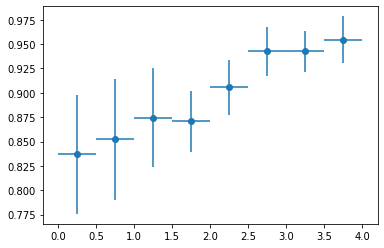

In [136]:
eta_center = (eta_cuts + eta_width/2)
plt.errorbar(eta_center, eta_eff_reshape.mean(0), eta_eff_reshape.std(0), eta_width/2, fmt="o")
# plt.ylim(0.96, 1.005)

<ErrorbarContainer object of 3 artists>

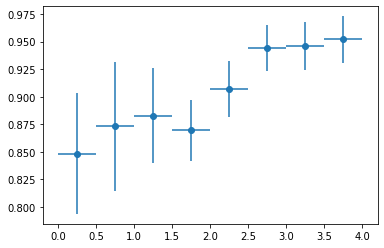

In [167]:
eta_center = (eta_cuts + eta_width/2)
plt.errorbar(eta_center, eta_eff_reshape.mean(0), eta_eff_reshape.std(0), eta_width/2, fmt="o")
# plt.ylim(0.96, 1.005)

In [168]:
print(f"Purity {np.array(eta_pur_list).mean()} +/- {np.array(eta_pur_list).std()}")

Purity 0.9872212209160697 +/- 0.0025795737930946827
